In [ ]:
!pip install pytorch-ignite
!pip3 install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
import json

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import shap
import numpy as np
from torch.utils.data import random_split
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

# load pre-trained model and data
model = ResNet50(weights="imagenet")
X, _ = shap.datasets.imagenet50()
print(X.shape, type(X[0][0][0]))
X = [torch.from_numpy(img) for img in X]
X = np.stack(X)
print(X.shape, type(X[0][0][0]))

# load our model and data#
#mri_transform = transforms.Compose([
#      transforms.RandomHorizontalFlip(),
#      transforms.RandomRotation(60),
#      transforms.ToTensor()
#      ])
#tumor_data = torchvision.datasets.ImageFolder(root="drive/My Drive/Explainable AI Group Work/resnet_model/resnet_data/tumor_images", transform=mri_transform)
#animal_data = torchvision.datasets.ImageFolder(root="drive/My Drive/Explainable AI Group Work/resnet_model/resnet_data/animal_images", transform=mri_transform)

102967424/102967424 [==============================] - 1s 0us/step
(50, 224, 224, 3) <class 'numpy.ndarray'>
(50, 224, 224, 3) <class 'numpy.ndarray'>


In [ ]:
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# How the model is structured
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)

        # Replace output layer according to our problem
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, 4)

    def forward(self, x):
        x = self.resnet18(x)
        return x

# get the model
#tumor_model = torch.load("drive/MyDrive/Explainable AI Group Work/Shapley/LevNetResNet18.pt", map_location=device)
tumor_model = torch.load("drive/MyDrive/Explainable AI Group Work/Shapley/mri_model_4class.pth", map_location=device)
tumor_model.eval()


pretrained_weights = models.ResNet18_Weights.IMAGENET1K_V1
animal_model = models.resnet18(weights=pretrained_weights)
animal_model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 29.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import PIL.Image as Image
import glob
import pickle

with open("drive/MyDrive/Explainable AI Group Work/Shapley/tumor_image_numpy.pickle", "rb") as f: tumor_X = pickle.load(f)

with open("drive/MyDrive/Explainable AI Group Work/Shapley/animal_image_numpy_unsorted.pickle", "rb") as f: animal_X = pickle.load(f)

def hashval(filepath):
  ending = filepath.split("/")[-1][:-4]
  animal, class_name, num = ending.split("-")
  num = int(num.split(" ")[0])
  total = (0 if animal == "dog" else 1)
  total = total*1000 + hash(class_name)%1000
  return total*1000 + num

tumor_filelist = glob.glob("drive/My Drive/Explainable AI Group Work/resnet_model/resnet_data/tumor_images/**/*")
#tumor_X = np.array([np.asarray(Image.open(filepath)) for filepath in tumor_filelist])
#with open("drive/MyDrive/Explainable AI Group Work/Shapley/tumor_image_numpy.pickle", "wb") as f: pickle.dump(tumor_X, f)

animal_filelist = glob.glob("drive/My Drive/Explainable AI Group Work/resnet_model/resnet_data/cat_dog_images/**/**/*")
animal_filelist.sort(key=hashval)
#animal_X = np.array([np.asarray(Image.open(filepath)) for filepath in animal_filelist])
#with open("drive/MyDrive/Explainable AI Group Work/Shapley/animal_image_numpy.pickle", "wb") as f: pickle.dump(animal_X, f)

In [ ]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

In [ ]:
# python function to get model output; replace this function with your own model function.
def f(x):
    print(x.shape)
    tmp = x.copy()
    preprocess_input(tmp)
    answer = model(tmp)
    print(type(answer), answer.shape)
    return answer

def tumor_predict(x):
    tmp = x.copy()
    preprocess_input(tmp)
    answer = tumor_model(tmp)
    return answer

def animal_predict(x):
    tmp = x.copy()
    preprocess_input(tmp)
    answer = animal_model(tmp)
    return answer


def filename_to_np(filepath):
    return np.asarray(Image.open(filepath))

def np_to_normalized_image(img):
    # Convert numpy array to PyTorch tensor and reorder dimensions if necessary
    img_tensor = torch.tensor(img).permute(0, 3, 1, 2).float()  # for a single image

    # Define normalization for 0-255 range images
    c=255
    mean = [0.485 * c, 0.456 * c, 0.406 * c]
    std = [0.229 * c, 0.224 * c, 0.225 * c]

    normalize = transforms.Normalize(mean=mean, std=std, inplace=True)

    # Apply normalization
    for img in img_tensor:
      normalize(img)

    # Add a batch dimension if processing a single image
    #img_normalized = img_normalized.unsqueeze(0)
    return img_tensor

def animal_torch_predict(x):
    if x.ndim == 4:
      return animal_model(np_to_normalized_image(x))
    #elif x.ndim == 3:
    #  return animal_model(np_to_normalized_image(x[np.newaxis]))

def tumor_torch_predict(x):
    if x.ndim == 4:
      normImg = np_to_normalized_image(x).to(device)
      return tumor_model(normImg)

In [ ]:
import matplotlib.pyplot as plt

masker_blur = shap.maskers.Image("blur(128,128)", tumor_X[0].shape)
explainer_blur = shap.Explainer(tumor_torch_predict, masker_blur, output_names=["glioma", "meningioma", "healthy", "pituitary"])
shap_values = explainer_blur(
  filename_to_np(tumor_filelist[51])[np.newaxis], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)
# Assuming `shap_values` is your SHAP values object for an image
# and `image` is the original image you explained.

# This is a placeholder; you'll need to adjust it based on your actual data structure
shap_data = np.mean(np.mean(shap_values.values[0], axis=-1)/(3*10**-5), axis=-1)


# Generate a simple plot - this is where you customize
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap (green to red)
colors = ["green", "red"]
# Create a colormap object
cmap_name = "green_to_red"
green_to_red_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
print(shap_data[0])
plt.imshow(shap_data, cmap=green_to_red_cmap) # Choose a colormap that fits your needs
plt.colorbar() # Show color scale
plt.show()

  0%|          | 0/49998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:48, 168.58s/it]              


Tumor: 2346 with filepath sick-glioma_tumor-0.jpg


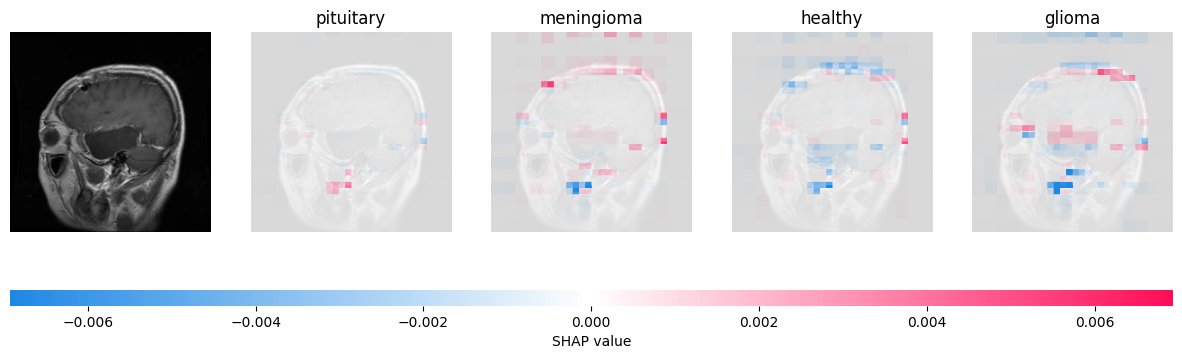

  0%|          | 0/49998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:47, 167.78s/it]              


Tumor: 51 with filepath sick-meningioma_tumor-45.jpg


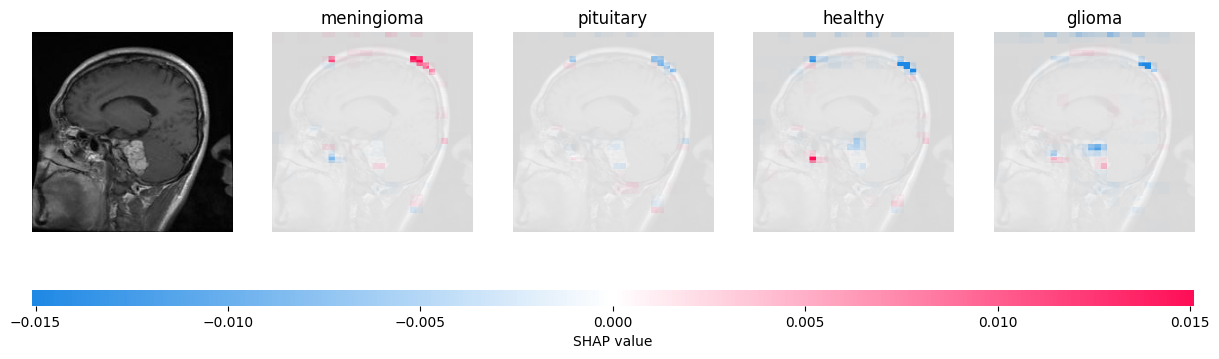

  0%|          | 0/49998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:48, 168.78s/it]              


Tumor: 1943 with filepath healthy-no_tumor-97.jpg


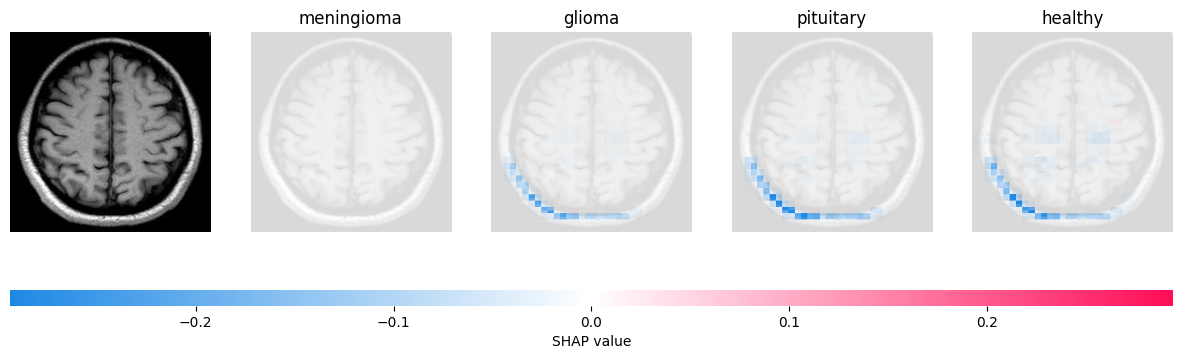

  0%|          | 0/49998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:53, 173.55s/it]              


Tumor: 1598 with filepath sick-pituitary_tumor-135.jpg


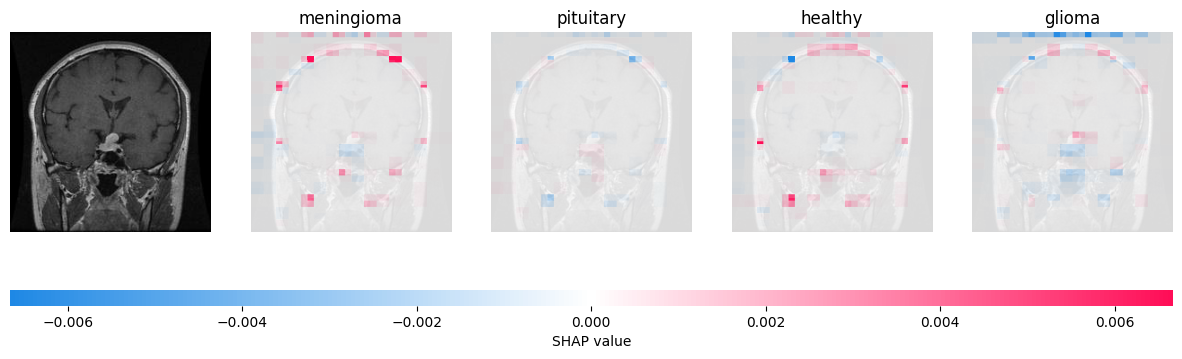

In [ ]:
tumors = [2346, 51, 1943, 1598]#[2000, 2001, 0, 1]# 2547, 276]
masker_blur = shap.maskers.Image("blur(128,128)", tumor_X[0].shape)
explainer_blur = shap.Explainer(tumor_torch_predict, masker_blur, output_names=["glioma", "meningioma", "healthy", "pituitary"])
for tumor_ID in tumors:
  # 4900 evals = 5 mins. 10000 evals = 35 mins. 40000 = 2.5 hours.

  shap_values_fine = explainer_blur(
      filename_to_np(tumor_filelist[tumor_ID])[np.newaxis], max_evals=50000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
  )
  print("Tumor:", tumor_ID, "with filepath", tumor_filelist[tumor_ID].split("/")[-1])
  #print(tumor_torch_predict(filename_to_np(tumor_filelist[tumor_ID])[np.newaxis]))
  shap.image_plot(shap_values_fine)


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

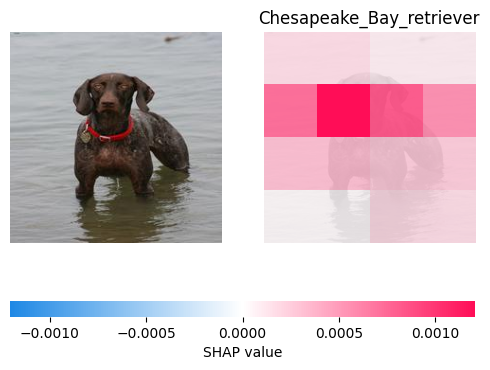

In [ ]:
animals = [3099]#, 2660, 4998, 5022, 6863, 5663, 4086, 3475]
masker_blur = shap.maskers.Image("blur(128,128)", animal_X[0].shape)
print(class_names)
explainer_blur = shap.Explainer(animal_torch_predict, masker_blur, output_names=class_names)
for animal_ID in animals:
  # 4900 evals = 5 mins. 10000 evals = 35 mins. 40000 = 2.5 hours.
  shap_values_fine = explainer_blur(
      filename_to_np(animal_filelist[animal_ID])[np.newaxis], max_evals=49, batch_size=50, outputs=shap.Explanation.argsort.flip[:1]
  )
  print("Animal:", animal_ID, "with filepath", animal_filelist[animal_ID].split("/")[-1])
  shap.image_plot(shap_values_fine)
